## Data Understanding and Prepocessing

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict
import numpy as np
import seaborn as sns
from scipy import stats

### a. Evaluate Data Completeness:

In [2]:
def load_csv_as_dataframes(folder_name: str, globals_dict: Dict) -> None:
    folder_path = Path(os.getcwd()) / folder_name

    if not folder_path.exists():
        print(f"Error: Folder '{folder_name}' not found!")
        return

    csv_files = list(folder_path.glob("*.csv"))
    if not csv_files:
        print(f"No CSV files found in the folder '{folder_name}'.")
        return

    for file_path in csv_files:
        var_name = file_path.stem  # Remove .csv extension for variable name
        try:
            df = pd.read_csv(file_path)

            globals_dict[var_name] = df  # Store as a global variable
            print(f"DataFrame '{var_name}' loaded successfully! Shape: {df.shape}")

        except Exception as e:
            print(f"Failed to read {file_path.name}: {e}")

def print_loaded_dataframes(globals_dict: Dict) -> None:
    loaded_vars = [var for var in globals_dict.keys() if isinstance(globals_dict[var], pd.DataFrame)]
    if loaded_vars:
        print("\nLoaded DataFrames:")
        print(loaded_vars)
    else:
        print("\nNo DataFrames were loaded.")

def analyze_dataframes(var_list):
    for var_name in var_list:
        df = globals().get(var_name)
        if df is None or not isinstance(df, pd.DataFrame):
            print(f"Warning: '{var_name}' is not a DataFrame or not found.")
            continue

        print(f"\nAnalyzing DataFrame: {var_name} (Shape: {df.shape})")
        print("=" * 60)

        # 1. Data Types
        print("\n1. Data Types:")
        display(df.dtypes)

        # 2. Missing Values
        print("\n2. Missing Values:")
        missing_values = df.isnull().sum()
        display(missing_values[missing_values > 0])

        # 3. Summary Statistics for Numeric Columns
        print("\n3. Summary Statistics for Numeric Columns:")
        numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
        if len(numeric_cols) > 0:
            display(df[numeric_cols].describe())
        else:
            print("No numeric columns found for summary statistics.")

        # 4. Histograms for Numeric Columns
        print("\n4. Histograms for Numeric Columns:")
        if len(numeric_cols) > 0:
            df[numeric_cols].hist(figsize=(12, 6), bins=20, edgecolor="black")
            plt.tight_layout()
            plt.show()
        else:
            print("No numeric columns found for histograms.")

        print("=" * 60, "\n")

def full_outer_join(farms, ponds, cycles, feeds, fasting, samplings, measurements, mortalities, feed_tray, harvests):
    datasets = {
        'feeds': feeds,
        'fasting': fasting,
        'samplings': samplings,
        'measurements': measurements,
        'mortalities': mortalities,
        'feed_tray': feed_tray,
        'harvests': harvests
    }

    # Convert cycle_id to numeric where applicable
    for name, df in datasets.items():
        if 'cycle_id' in df.columns:
            df['cycle_id'] = pd.to_numeric(df['cycle_id'], errors='coerce').astype('Int64')

    # Sample datasets before merging (if they exceed 2000 rows)
    sampled_datasets = {name: df.sample(n=1000, random_state=42) if df.shape[0] > 1000 else df for name, df in datasets.items()}

    # Merge farms, ponds, and cycles first
    farms_ponds = farms.merge(ponds, left_on='id', right_on='farm_id', how='outer', suffixes=('_farm', '_pond'))
    farms_ponds_cycles = farms_ponds.merge(cycles, left_on='id_pond', right_on='pond_id', how='outer', suffixes=('_pond', '_cycle'))

    if 'id' in farms_ponds_cycles.columns:
        farms_ponds_cycles = farms_ponds_cycles.rename(columns={'id': 'cycle_id'})

    merged_df = farms_ponds_cycles

    # Merge sampled datasets while resolving column conflicts
    for name, dataset in sampled_datasets.items():
        common_cols = set(merged_df.columns) & set(dataset.columns)
        common_cols.discard("cycle_id")  # Ensure cycle_id is not renamed
        dataset = dataset.rename(columns={col: f"{col}_{name}" for col in common_cols})
        
        merged_df = merged_df.merge(dataset, on='cycle_id', how='outer', suffixes=(None, f'_{name}'))

    return merged_df


def handle_missing_values(merged_df: pd.DataFrame, threshold: float = 0.9) -> pd.DataFrame:
    # Debug: Print initial DataFrame shape and columns
    print(f"Initial DataFrame shape: {merged_df.shape}")
    print(f"Initial columns: {merged_df.columns.tolist()}")

    # 1. Flag rows with missing 'farm_id', 'province', or 'regency'
    required_cols = ['farm_id', 'province', 'regency']
    if all(col in merged_df.columns for col in required_cols):
        merged_df['_missing_required'] = merged_df[required_cols].isnull().any(axis=1)
    else:
        print(f"Warning: Required columns {required_cols} not found. Skipping this step.")
        merged_df['_missing_required'] = False  # Assume no missing required columns

    # Debug: Print count of rows with missing required columns
    print(f"Rows with missing 'farm_id', 'province', or 'regency': {merged_df['_missing_required'].sum()}")

    # 2. Remove rows with too many missing values
    num_columns = len(merged_df.columns)
    merged_df['missing_count'] = merged_df.isnull().sum(axis=1)
    merged_df = merged_df[merged_df['missing_count'] <= (threshold * num_columns)]
    merged_df = merged_df.drop(columns=['missing_count'])  # Drop the temporary column

    # Debug: Print DataFrame shape after removing rows with too many missing values
    print(f"DataFrame shape after removing rows with too many missing values: {merged_df.shape}")

    # 3. Sort the DataFrame by 'farm_id' and 'created_date' (oldest to newest) for rows with non-missing 'farm_id'
    if 'farm_id' in merged_df.columns and 'created_date' in merged_df.columns:
        # Ensure 'created_date' is datetime
        merged_df['created_date'] = pd.to_datetime(merged_df['created_date'], errors='coerce')
        # Sort only rows where 'farm_id' is not missing
        merged_df_sorted = merged_df[~merged_df['_missing_required']].sort_values(by=['farm_id', 'created_date'])
        # Combine sorted and unsorted rows
        merged_df = pd.concat([merged_df_sorted, merged_df[merged_df['_missing_required']]], ignore_index=True)
    else:
        print("Warning: 'farm_id' or 'created_date' columns not found. Skipping sorting.")

    # Debug: Print unique farm_ids after sorting
    if 'farm_id' in merged_df.columns:
        print(f"Unique farm_ids after sorting: {merged_df['farm_id'].unique()}")

    # 4. Impute missing numeric values using the median
    numeric_cols = merged_df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        if merged_df[col].isnull().any():  # Only impute if there are missing values
            merged_df[col] = merged_df[col].fillna(merged_df[col].median())

    # Debug: Print missing values after numeric imputation
    print("Missing values after numeric imputation:")
    print(merged_df[numeric_cols].isnull().sum())

    # 5. Impute missing categorical values using the mode
    categorical_cols = merged_df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if merged_df[col].isnull().any():  # Only impute if there are missing values
            mode_value = merged_df[col].mode()
            merged_df[col] = merged_df[col].fillna(mode_value[0] if not mode_value.empty else "Unknown")

    # Debug: Print missing values after categorical imputation
    print("Missing values after categorical imputation:")
    print(merged_df[categorical_cols].isnull().sum())

    # 6. Drop the temporary column '_missing_required'
    merged_df = merged_df.drop(columns=['_missing_required'])

    # Debug: Print final DataFrame shape and columns
    print(f"Final DataFrame shape: {merged_df.shape}")
    print(f"Final columns: {merged_df.columns.tolist()}")

    return merged_df

def remove_duplicates(df: pd.DataFrame, subset: list = None, keep: str = 'first') -> pd.DataFrame:
    num_duplicates = df.duplicated(subset=subset, keep=keep).sum()

    if num_duplicates > 0:
        print(f"Found {num_duplicates} duplicate rows. Removing duplicates...")
        df_cleaned = df.drop_duplicates(subset=subset, keep=keep)
        print(f"Removed {num_duplicates} duplicate rows. Cleaned DataFrame shape: {df_cleaned.shape}")
    else:
        print("No duplicates found.")
        df_cleaned = df

    return df_cleaned

DataFrame 'samplings' loaded successfully! Shape: (15032, 7)
DataFrame 'fasting' loaded successfully! Shape: (6189, 3)
DataFrame 'measurements' loaded successfully! Shape: (139050, 24)
DataFrame 'feeds' loaded successfully! Shape: (706908, 3)
DataFrame 'farms' loaded successfully! Shape: (551, 4)
DataFrame 'mortalities' loaded successfully! Shape: (13221, 7)
DataFrame 'ponds' loaded successfully! Shape: (338, 10)
DataFrame 'cycles' loaded successfully! Shape: (2617, 24)
DataFrame 'feed_tray' loaded successfully! Shape: (186664, 10)
DataFrame 'harvests' loaded successfully! Shape: (8087, 9)
DataFrame 'fastings' loaded successfully! Shape: (32379, 3)

Loaded DataFrames:
['samplings', 'fasting', 'measurements', 'feeds', 'farms', 'mortalities', 'ponds', 'cycles', 'feed_tray', 'harvests', 'fastings']

Analyzing DataFrame: samplings (Shape: (15032, 7))

1. Data Types:


cycle_id          float64
updated_at         object
sampled_at         object
created_at         object
average_weight    float64
id                float64
remark             object
dtype: object


2. Missing Values:


remark    13693
dtype: int64


3. Summary Statistics for Numeric Columns:


,cycle_id,average_weight,id
count,15032.000000,15032.000000,15032.000000
mean,19982.632052,9.900390,38925.218068
std,5742.703137,7.187137,13394.422325
min,3458.000000,0.010000,5308.000000
25%,16650.500000,4.490000,29964.750000
50%,20401.000000,8.130000,38806.500000
75%,24690.000000,13.772500,49932.250000
max,29874.000000,100.000000,61775.000000



4. Histograms for Numeric Columns:


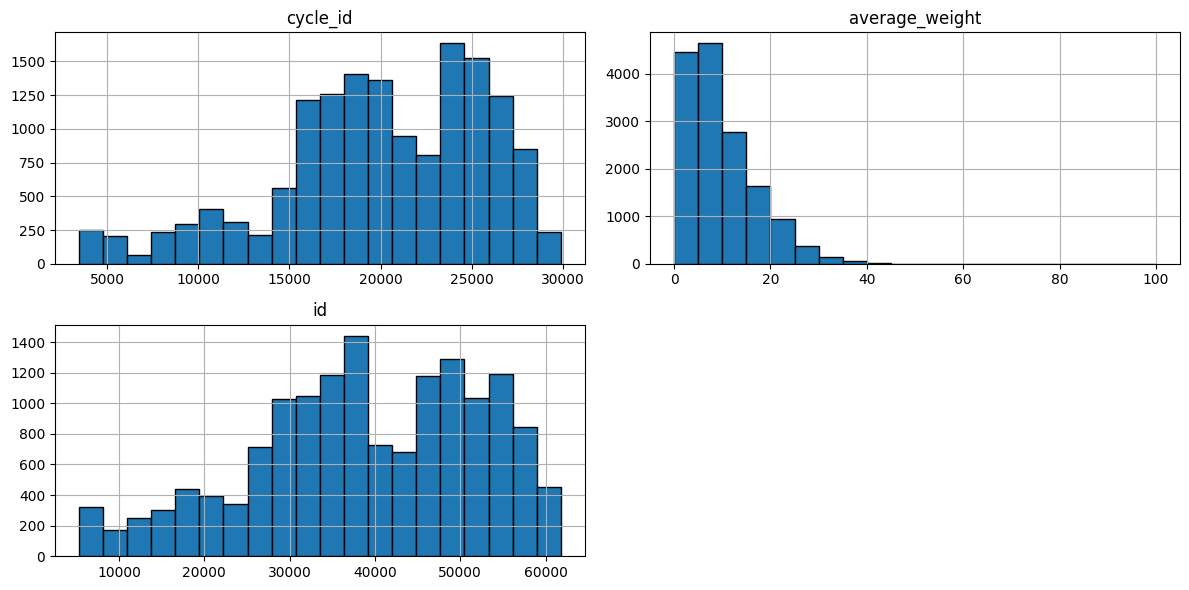



Analyzing DataFrame: fasting (Shape: (6189, 3))

1. Data Types:


logged_date     object
cycle_id         int64
fasting        float64
dtype: object


2. Missing Values:


fasting    17
dtype: int64


3. Summary Statistics for Numeric Columns:


,cycle_id,fasting
count,6189.000000,6172.000000
mean,17675.134755,0.242547
std,2820.779258,0.428658
min,7616.000000,0.000000
25%,16091.000000,0.000000
50%,17832.000000,0.000000
75%,19318.000000,0.000000
max,23531.000000,1.000000



4. Histograms for Numeric Columns:


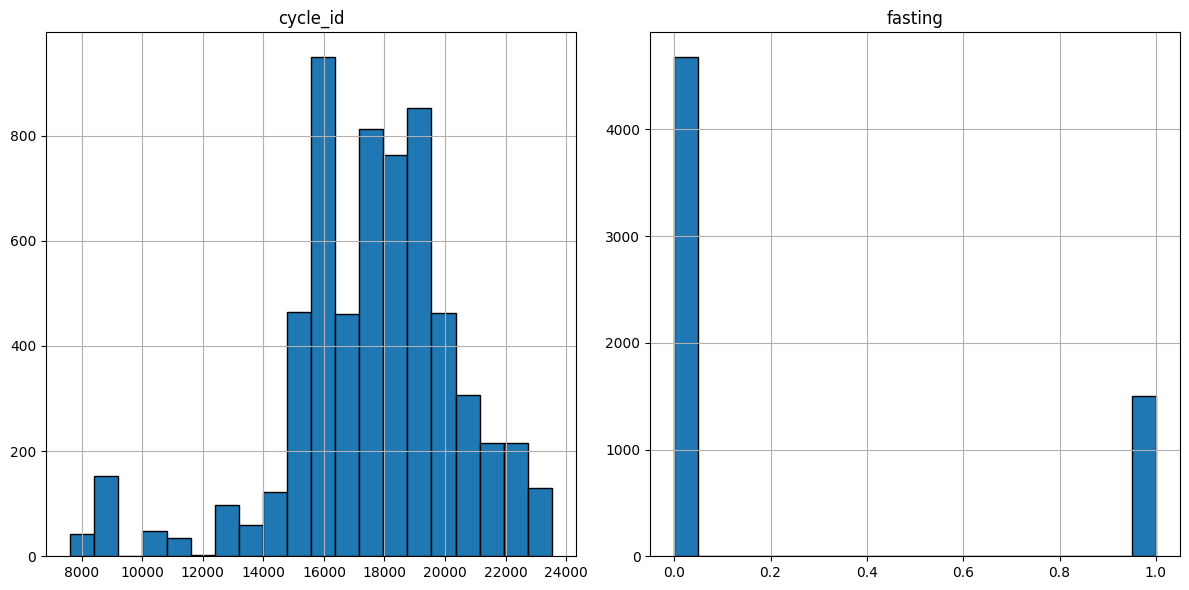



Analyzing DataFrame: measurements (Shape: (139050, 24))

1. Data Types:


pond_id                  int64
cycle_id                 int64
measured_date           object
morning_temperature    float64
evening_temperature    float64
morning_do             float64
evening_do             float64
morning_salinity       float64
evening_salinity       float64
morning_pH             float64
evening_pH             float64
transparency           float64
turbidity              float64
ammonia                float64
nitrate                float64
nitrite                float64
alkalinity             float64
hardness               float64
calcium                float64
magnesium              float64
carbonate              float64
bicarbonate            float64
tom                    float64
total_plankton_        float64
dtype: object


2. Missing Values:


morning_temperature     41855
evening_temperature     49839
morning_do              61324
evening_do              65098
morning_salinity        46388
evening_salinity        73957
morning_pH              20115
evening_pH              78101
transparency            61750
turbidity              138884
ammonia                135302
nitrate                136888
nitrite                129293
alkalinity             125533
hardness               133525
calcium                132458
magnesium              132430
carbonate              133762
bicarbonate            132372
tom                    131774
total_plankton_        126429
dtype: int64


3. Summary Statistics for Numeric Columns:


,pond_id,cycle_id,morning_temperature,evening_temperature,morning_do,evening_do,morning_salinity,evening_salinity,morning_pH,evening_pH,...,nitrate,nitrite,alkalinity,hardness,calcium,magnesium,carbonate,bicarbonate,tom,total_plankton_
count,139050.000000,139050.00000,97195.000000,89211.000000,77726.000000,73952.000000,92662.000000,65093.000000,118935.000000,60949.000000,...,2162.000000,9757.000000,13517.000000,5.525000e+03,6592.000000,6620.000000,5288.000000,6678.000000,7276.000000,1.262100e+04
mean,32589.530004,20268.85329,28.580945,29.908567,5.904100,6.005278,22.777202,22.090321,8.006981,8.212628,...,14.714262,16.400004,124.674397,5.074470e+03,576.667025,1959.711167,12.632430,136.527253,147.341025,5.464905e+05
std,10228.906407,5401.43651,106.896789,5.817013,216.810423,30.444501,60.788610,152.692575,22.025251,5.094369,...,33.204082,655.855878,182.072375,2.693992e+04,410.013047,1769.190137,89.049388,245.061763,1655.003075,2.228631e+06
min,1.000000,3458.00000,0.000000,0.000000,-52.885000,-62.837000,-25.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-15.170000,0.000000e+00
25%,30606.000000,16776.00000,27.000000,28.900000,4.231000,4.831000,16.800000,15.688000,7.615000,7.900000,...,1.000000,0.019000,100.000000,3.800000e+03,320.000000,930.000000,0.000000,104.000000,64.927500,3.000000e+00
50%,34706.000000,20197.00000,28.000000,30.000000,4.970000,5.640000,23.000000,21.400000,7.900000,8.200000,...,5.000000,0.060000,125.300000,5.050000e+03,421.000000,1200.000000,0.000000,125.000000,87.585000,2.000000e+05
75%,39152.000000,24739.00000,29.000000,31.000000,5.640000,6.500000,29.000000,26.950000,8.120000,8.412000,...,20.000000,0.432000,154.000000,5.757000e+03,800.000000,2850.000000,12.000000,152.000000,106.000000,6.900000e+05
max,47282.000000,29874.00000,27341.000000,1078.933333,60043.000000,6706.000000,15734.000000,33958.000000,7421.000000,862.000000,...,1272.000000,48031.000000,19589.000000,2.000000e+06,11250.000000,32000.000000,2400.000000,19589.000000,73312.000000,2.125053e+08



4. Histograms for Numeric Columns:


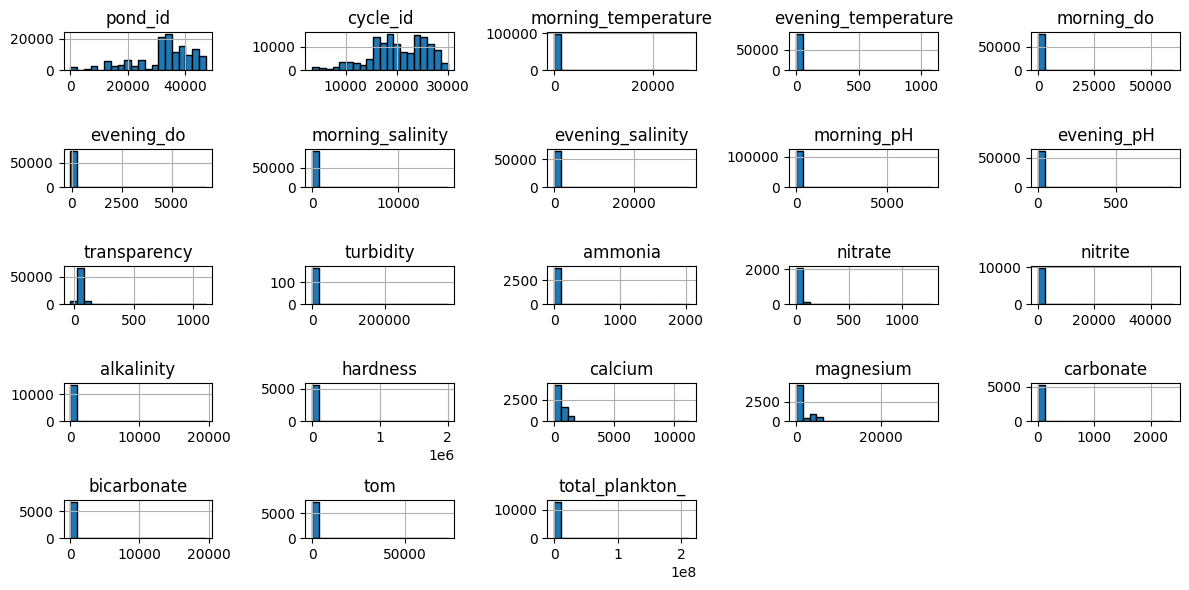



Analyzing DataFrame: feeds (Shape: (706908, 3))

1. Data Types:


cycle_id       int64
logged_at     object
quantity     float64
dtype: object


2. Missing Values:


logged_at    21
quantity     21
dtype: int64


3. Summary Statistics for Numeric Columns:


,cycle_id,quantity
count,706908.000000,706887.000000
mean,21890.928919,17.064466
std,5434.180295,22.536168
min,3458.000000,-1.000000
25%,18395.000000,4.000000
50%,23633.000000,10.000000
75%,27089.000000,22.000000
max,29874.000000,2011.000000



4. Histograms for Numeric Columns:


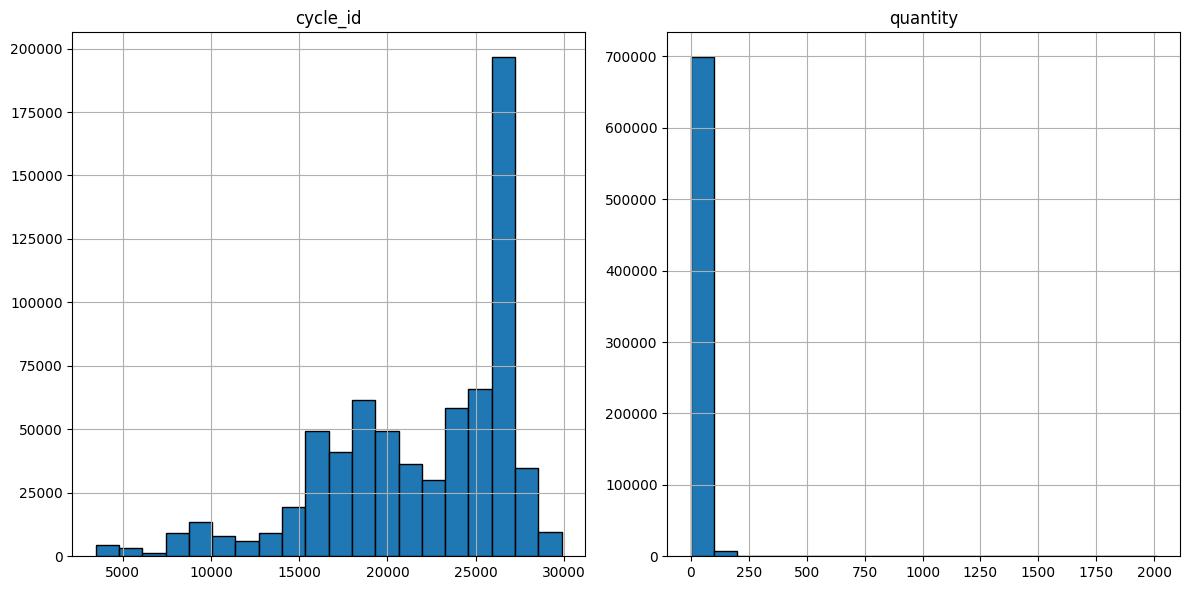



Analyzing DataFrame: farms (Shape: (551, 4))

1. Data Types:


id           int64
province    object
regency     object
timezone    object
dtype: object


2. Missing Values:


province    72
regency     93
dtype: int64


3. Summary Statistics for Numeric Columns:


,id
count,551.000000
mean,8625.956443
std,2937.544875
min,652.000000
25%,6369.500000
50%,8531.000000
75%,10710.000000
max,13886.000000



4. Histograms for Numeric Columns:


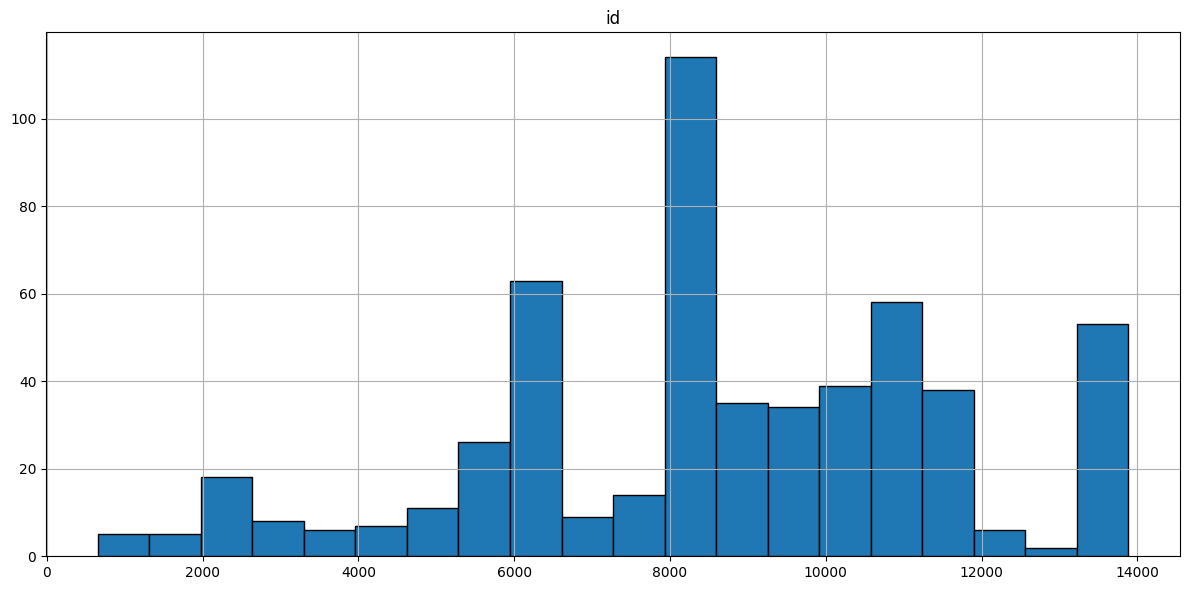



Analyzing DataFrame: mortalities (Shape: (13221, 7))

1. Data Types:


id                  int64
cycle_id            int64
quantity            int64
recorded_at        object
created_at         object
updated_at         object
average_weight    float64
dtype: object


2. Missing Values:


Series([], dtype: int64)


3. Summary Statistics for Numeric Columns:


,id,cycle_id,quantity,average_weight
count,13221.000000,13221.000000,1.322100e+04,13221.000000
mean,14307.947810,20844.158763,1.834642e+03,9.613240
std,5630.215217,4098.897296,8.721018e+04,17.196472
min,185.000000,7273.000000,1.000000e+00,0.000000
25%,9763.000000,17726.000000,6.000000e+01,4.550000
50%,13998.000000,19676.000000,2.000000e+02,7.890000
75%,18858.000000,24092.000000,7.560000e+02,13.040000
max,26192.000000,29579.000000,1.000000e+07,1428.570000



4. Histograms for Numeric Columns:


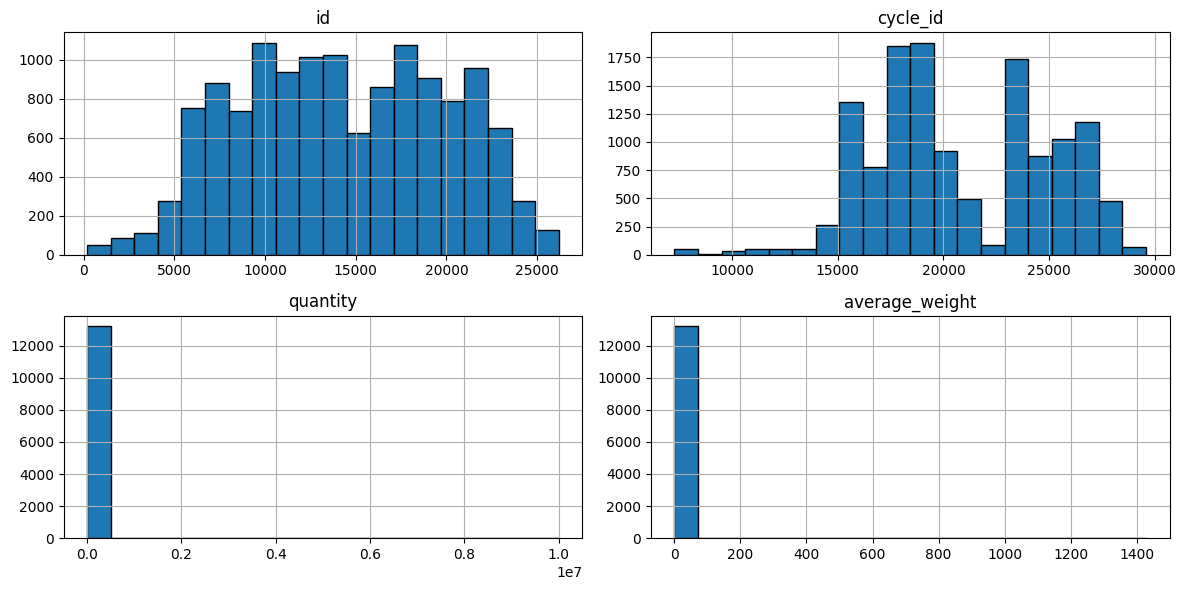



Analyzing DataFrame: ponds (Shape: (338, 10))

1. Data Types:


id                    int64
farm_id               int64
length              float64
width               float64
deep                float64
created_at           object
updated_at           object
record_id            object
extracted_at         object
max_seed_density    float64
dtype: object


2. Missing Values:


length               23
width                29
deep                 92
max_seed_density    203
dtype: int64


3. Summary Statistics for Numeric Columns:


,id,farm_id,length,width,deep,max_seed_density
count,338.000000,338.000000,315.000000,309.000000,246.000000,135.000000
mean,36899.159763,10151.973373,46.604698,29.845825,7.133537,248.672850
std,12968.985879,4008.835331,37.879973,18.142403,26.681219,1077.046893
min,1.000000,2.000000,0.600000,0.450000,0.900000,0.000625
25%,28825.250000,7365.000000,30.000000,20.000000,1.000000,63.783784
50%,44596.500000,12546.500000,36.510000,30.000000,1.300000,120.000000
75%,44702.750000,12562.000000,50.000000,40.000000,1.600000,185.205992
max,47762.000000,13378.000000,253.660000,190.240000,150.000000,12500.000000



4. Histograms for Numeric Columns:


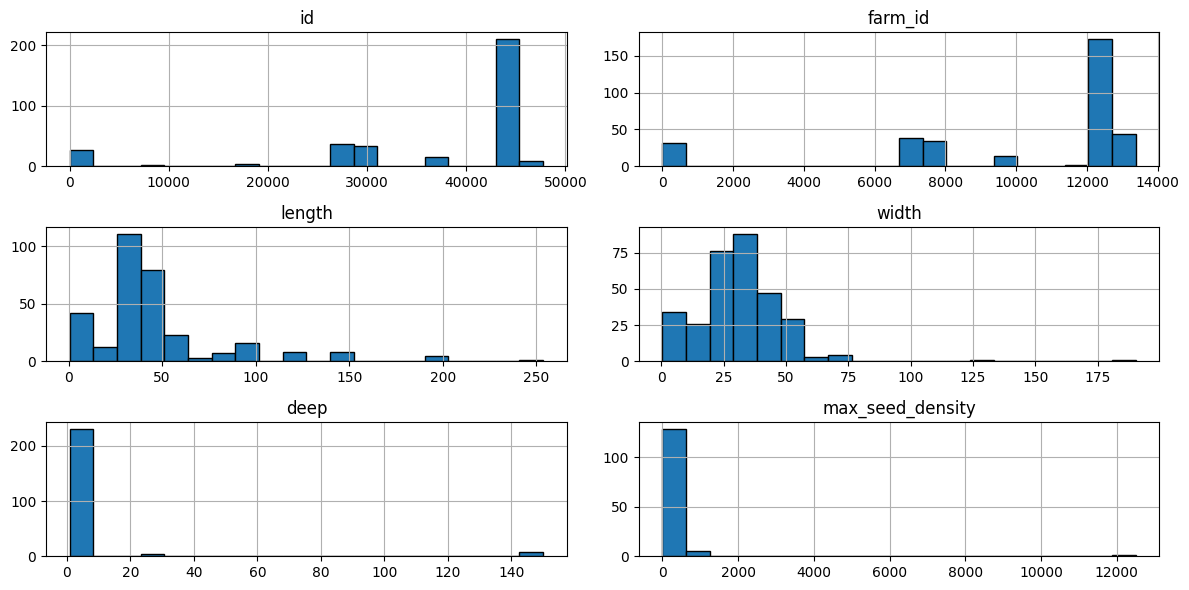



Analyzing DataFrame: cycles (Shape: (2617, 24))

1. Data Types:


id                          int64
pond_id                     int64
species_id                float64
total_seed                  int64
started_at                 object
finished_at                object
remark                     object
created_at                 object
updated_at                 object
area                      float64
initial_age               float64
limit_weight_per_area     float64
target_cultivation_day    float64
target_size               float64
extracted_at               object
subscription_type          object
ordered_at                 object
hatchery_id               float64
total_seed_type            object
hatchery_name              object
pond_name                  object
pond_length               float64
pond_width                float64
pond_depth                float64
dtype: object


2. Missing Values:


species_id                 814
finished_at                  1
remark                    1281
initial_age                 48
limit_weight_per_area        7
target_cultivation_day       3
target_size                  4
ordered_at                1523
hatchery_id                465
total_seed_type            242
hatchery_name              465
pond_length                  6
pond_width                   6
pond_depth                 118
dtype: int64


3. Summary Statistics for Numeric Columns:


,id,pond_id,species_id,total_seed,area,initial_age,limit_weight_per_area,target_cultivation_day,target_size,hatchery_id,pond_length,pond_width,pond_depth
count,2617.000000,2617.000000,1803.000000,2.617000e+03,2617.000000,2569.000000,2610.000000,2614.000000,2613.000000,2152.000000,2611.000000,2611.000000,2499.000000
mean,19900.667176,32218.568972,1.113699,2.197552e+05,2292.673653,0.704944,1.559452,112.591813,52.696135,412.304368,44.169694,36.299874,4.207935
std,6006.802428,10156.254276,0.317534,1.710980e+05,12104.748470,4.744826,6.640846,23.564663,22.803397,472.518010,26.640087,23.034006,19.647010
min,3458.000000,1.000000,1.000000,1.000000e+01,1.020000,0.000000,0.600000,0.000000,0.000000,1.000000,3.000000,1.500000,0.600000
25%,16091.000000,24570.000000,1.000000,9.600000e+04,810.000000,0.000000,1.250000,100.000000,45.000000,35.000000,30.000000,26.230000,1.000000
50%,20401.000000,34697.000000,1.000000,1.943920e+05,1400.000000,0.000000,1.250000,120.000000,55.000000,83.000000,40.000000,34.500000,1.300000
75%,24804.000000,38943.000000,1.000000,3.000000e+05,2358.000000,0.000000,1.250000,120.000000,55.000000,1004.000000,53.000000,44.720000,1.500000
max,29874.000000,47282.000000,2.000000,1.800000e+06,422500.000000,75.000000,270.000000,348.000000,1000.000000,1077.000000,650.000000,650.000000,300.000000



4. Histograms for Numeric Columns:


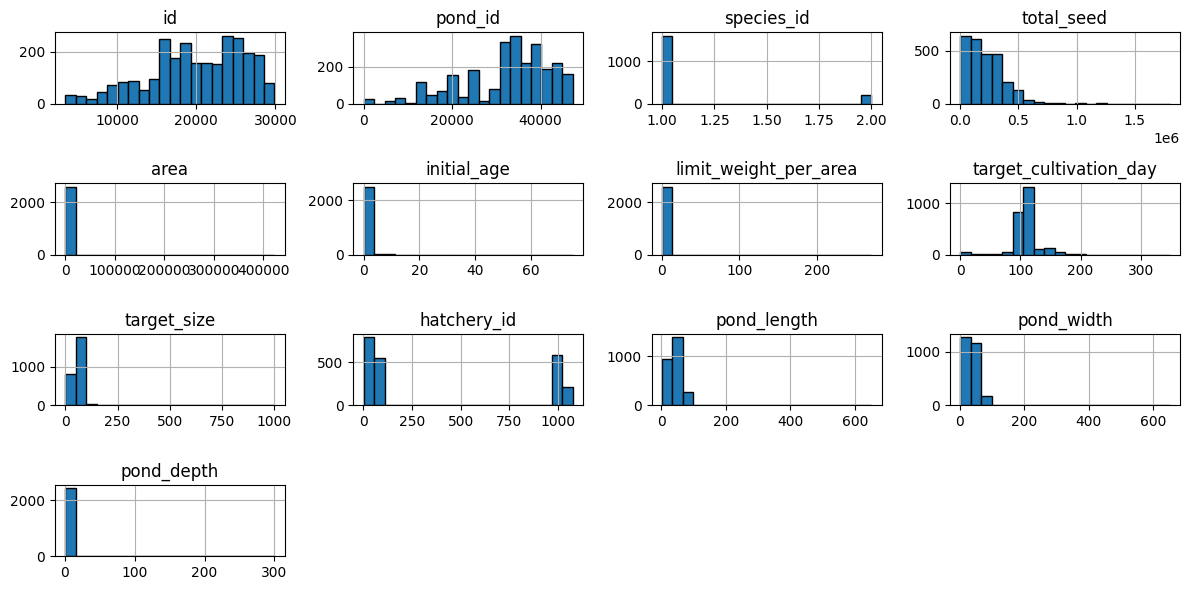



Analyzing DataFrame: feed_tray (Shape: (186664, 10))

1. Data Types:


id                         int64
logged_at                 object
feed_logged_at            object
cycle_id                   int64
tray_number                int64
feed_remaining_percent     int64
remark                    object
created_at                object
updated_at                object
local_feed_logged_at      object
dtype: object


2. Missing Values:


remark    140283
dtype: int64


3. Summary Statistics for Numeric Columns:


,id,cycle_id,tray_number,feed_remaining_percent
count,186664.000000,186664.000000,186664.000000,186664.000000
mean,123263.899429,20091.738193,1.950221,10.079935
std,67748.121524,4137.425172,1.077650,19.511848
min,498.000000,12163.000000,1.000000,0.000000
25%,63660.750000,16162.000000,1.000000,0.000000
50%,122951.500000,19253.000000,2.000000,0.000000
75%,180322.250000,23739.000000,3.000000,0.000000
max,285950.000000,29874.000000,6.000000,66.000000



4. Histograms for Numeric Columns:


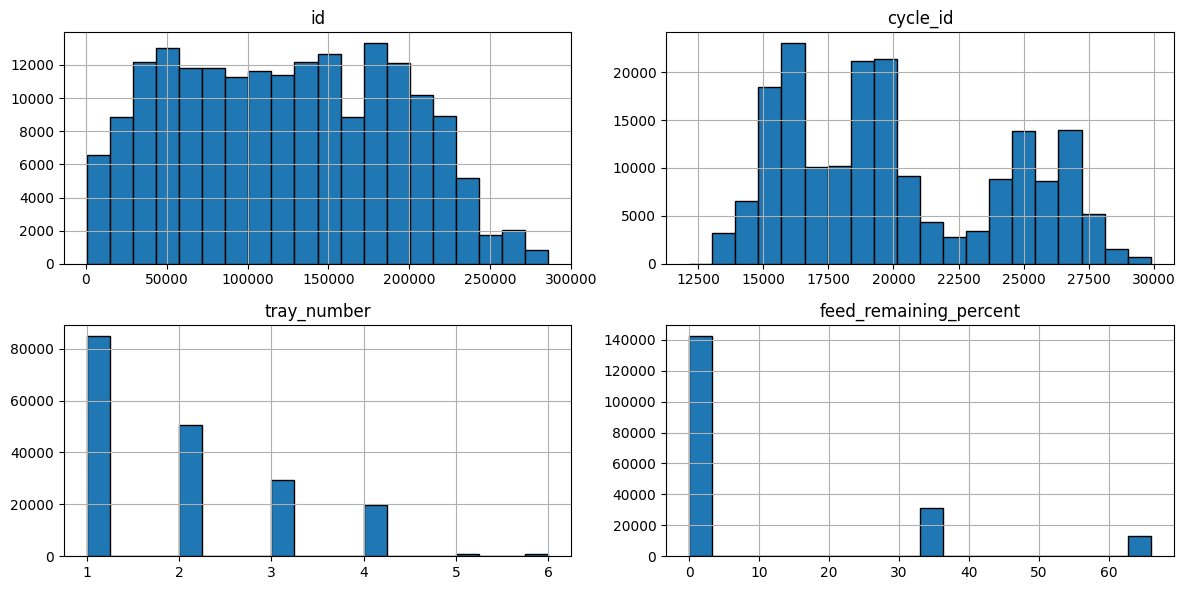



Analyzing DataFrame: harvests (Shape: (8087, 9))

1. Data Types:


cycle_id         float64
updated_at        object
size             float64
created_at        object
weight           float64
id               float64
harvested_at      object
status            object
selling_price    float64
dtype: object


2. Missing Values:


status            263
selling_price    1793
dtype: int64


3. Summary Statistics for Numeric Columns:


,cycle_id,size,weight,id,selling_price
count,8087.000000,8087.000000,8087.000000,8087.000000,6.294000e+03
mean,19871.768023,113.803389,774.636121,17307.678744,3.181221e+07
std,5785.357384,381.149658,4266.747605,6714.157986,1.646234e+08
min,3458.000000,10.000000,0.000000,2052.000000,0.000000e+00
25%,16342.500000,60.000000,47.970000,12549.500000,2.989368e+05
50%,19672.000000,86.000000,250.000000,16555.000000,6.247500e+06
75%,24742.500000,125.000000,667.695000,23111.500000,2.589123e+07
max,29874.000000,20000.000000,250000.000000,28468.000000,1.125000e+10



4. Histograms for Numeric Columns:


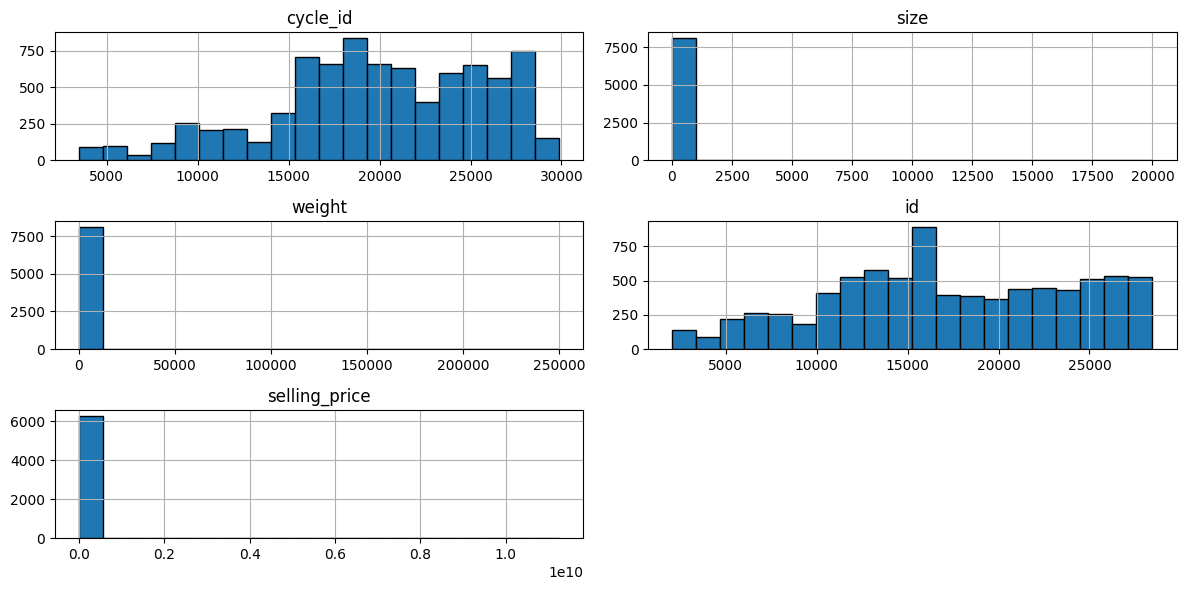



Analyzing DataFrame: fastings (Shape: (32379, 3))

1. Data Types:


logged_date     object
cycle_id       float64
fasting        float64
dtype: object


2. Missing Values:


fasting    40
dtype: int64


3. Summary Statistics for Numeric Columns:


,cycle_id,fasting
count,32379.000000,32339.000000
mean,20198.647364,0.269025
std,4592.291087,0.443460
min,4036.000000,0.000000
25%,17307.000000,0.000000
50%,18919.000000,0.000000
75%,24321.000000,1.000000
max,29659.000000,1.000000



4. Histograms for Numeric Columns:


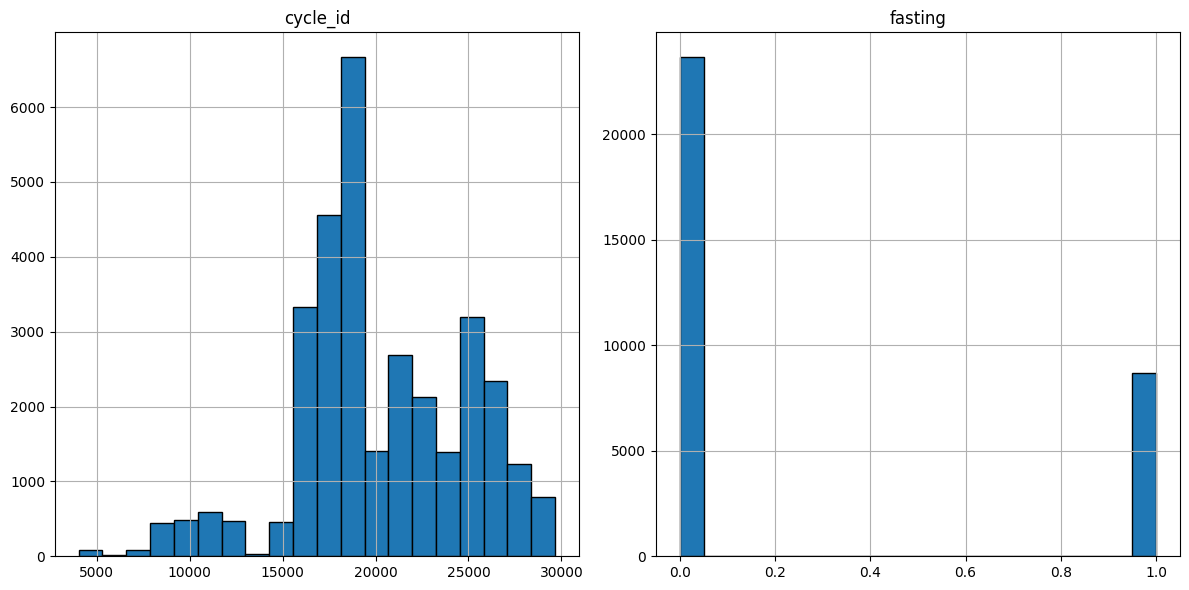

In [3]:
#--- data loading -----------------------------
data_folder = "data"
load_csv_as_dataframes(data_folder, globals())
print_loaded_dataframes(globals())

#--- data analysis -----------------------------
# Get list of loaded DataFrames
loaded_vars = [var for var in globals().keys() if isinstance(globals()[var], pd.DataFrame)]
analyze_dataframes(loaded_vars)  # Use the list of DataFrame variables


In [4]:
#--- full outer join -----------------------------
merged_df = full_outer_join(farms, ponds, cycles, feeds, fasting, samplings, measurements, mortalities, feed_tray, harvests)

#--- handling missing values -----------------------------
merged_df = handle_missing_values(merged_df, threshold=0.7)

#--- removing duplicates -----------------------------
merged_df = remove_duplicates(merged_df, subset=None, keep='first')

Initial DataFrame shape: (11997, 94)
Initial columns: ['id_farm', 'province', 'regency', 'timezone', 'id_pond', 'farm_id', 'length', 'width', 'deep', 'created_at_pond', 'updated_at_pond', 'record_id', 'extracted_at_pond', 'max_seed_density', 'cycle_id', 'pond_id', 'species_id', 'total_seed', 'started_at', 'finished_at', 'remark', 'created_at_cycle', 'updated_at_cycle', 'area', 'initial_age', 'limit_weight_per_area', 'target_cultivation_day', 'target_size', 'extracted_at_cycle', 'subscription_type', 'ordered_at', 'hatchery_id', 'total_seed_type', 'hatchery_name', 'pond_name', 'pond_length', 'pond_width', 'pond_depth', 'logged_at', 'quantity', 'logged_date', 'fasting', 'updated_at', 'sampled_at', 'created_at', 'average_weight', 'id', 'remark_samplings', 'pond_id_measurements', 'measured_date', 'morning_temperature', 'evening_temperature', 'morning_do', 'evening_do', 'morning_salinity', 'evening_salinity', 'morning_pH', 'evening_pH', 'transparency', 'turbidity', 'ammonia', 'nitrate', 'nit

In [5]:
display(merged_df)

,id_farm,province,regency,timezone,id_pond,farm_id,length,width,deep,created_at_pond,...,updated_at_feed_tray,local_feed_logged_at,updated_at_harvests,size,created_at_harvests,weight,id_harvests,harvested_at,status,selling_price
5,12537.0,SULAWESI BARAT,MAMUJU UTARA,+07:00,5.0,3.0,45.81,33.0,1.1,2018-03-07 19:05:09.000,...,2022-10-16 06:58:09,2022-10-12 00:00:00,2022-10-06 05:10:14,79.0,2020-07-02 06:40:12,199.7,2306.0,2020-07-02,Partial,12414950.0
6,12537.0,SULAWESI BARAT,MAMUJU UTARA,+07:00,5.0,3.0,45.81,33.0,1.1,2018-03-07 19:05:09.000,...,2022-10-16 06:58:09,2022-10-12 00:00:00,2022-10-06 05:10:14,79.0,2020-07-02 06:40:12,199.7,2306.0,2020-07-02,Partial,12414950.0
7,12537.0,SULAWESI BARAT,MAMUJU UTARA,+07:00,5.0,3.0,45.81,33.0,1.1,2018-03-07 19:05:09.000,...,2022-10-16 06:58:09,2022-10-12 00:00:00,2022-10-06 05:10:14,79.0,2020-07-02 06:40:12,199.7,2306.0,2020-07-02,Partial,12414950.0
8,12537.0,SULAWESI BARAT,MAMUJU UTARA,+07:00,5.0,3.0,45.81,33.0,1.1,2018-03-07 19:05:09.000,...,2022-10-16 06:58:09,2022-10-12 00:00:00,2022-10-06 05:10:14,79.0,2020-07-02 06:40:12,199.7,2306.0,2020-07-02,Partial,12414950.0
9,12537.0,SULAWESI BARAT,MAMUJU UTARA,+07:00,5.0,3.0,45.81,33.0,1.1,2018-03-07 19:05:09.000,...,2022-10-16 06:58:09,2022-10-12 00:00:00,2022-10-06 05:10:14,79.0,2020-07-02 06:40:12,199.7,2306.0,2020-07-02,Partial,12414950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11129,12537.0,SULAWESI BARAT,MAMUJU UTARA,+07:00,5.0,3.0,45.81,33.0,1.1,2018-03-07 19:05:09.000,...,2024-03-17 03:17:03,2024-03-12 11:00:00,2022-10-06 05:25:50,72.0,2022-06-21 08:04:03,150.0,16458.0,2023-03-12,Partial,5064000.0
11131,12537.0,SULAWESI BARAT,MAMUJU UTARA,+07:00,5.0,3.0,45.81,33.0,1.1,2018-03-07 19:05:09.000,...,2022-10-16 06:58:09,2022-10-12 00:00:00,2024-03-31 23:31:48,140.0,2024-03-31 23:31:48,330.0,28159.0,2024-03-30,Full,16500000.0
11139,12537.0,SULAWESI BARAT,MAMUJU UTARA,+07:00,5.0,3.0,45.81,33.0,1.1,2018-03-07 19:05:09.000,...,2024-03-22 06:11:32,2024-03-21 13:00:00,2024-04-03 15:36:51,85.0,2024-04-03 05:20:38,1038.0,28263.0,2024-03-25,Full,57401400.0
11140,12537.0,SULAWESI BARAT,MAMUJU UTARA,+07:00,5.0,3.0,45.81,33.0,1.1,2018-03-07 19:05:09.000,...,2024-03-15 06:57:39,2024-03-15 16:00:00,2024-04-03 15:36:51,85.0,2024-04-03 05:20:38,1038.0,28263.0,2024-03-25,Full,57401400.0


## Data Understanding & Preprocessing
### b. Exploratory Data Analysis (EDA)

In [6]:
df = merged_df.copy()

# Check missing values
print(df.isnull().sum())

id_farm          0
province         0
regency          0
timezone         0
id_pond          0
                ..
weight           0
id_harvests      0
harvested_at     0
status           0
selling_price    0
Length: 94, dtype: int64


In [7]:
# Check duplicates
print(df.duplicated().sum())

0


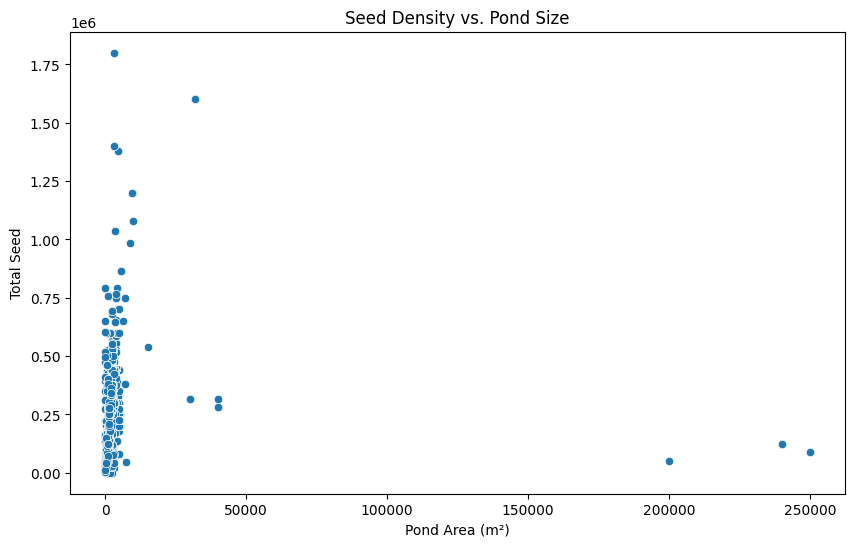

In [8]:
# Seed Density vs. Pond Size
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["area"], y=df["total_seed"])
plt.title("Seed Density vs. Pond Size")
plt.xlabel("Pond Area (m²)")
plt.ylabel("Total Seed")
plt.show()

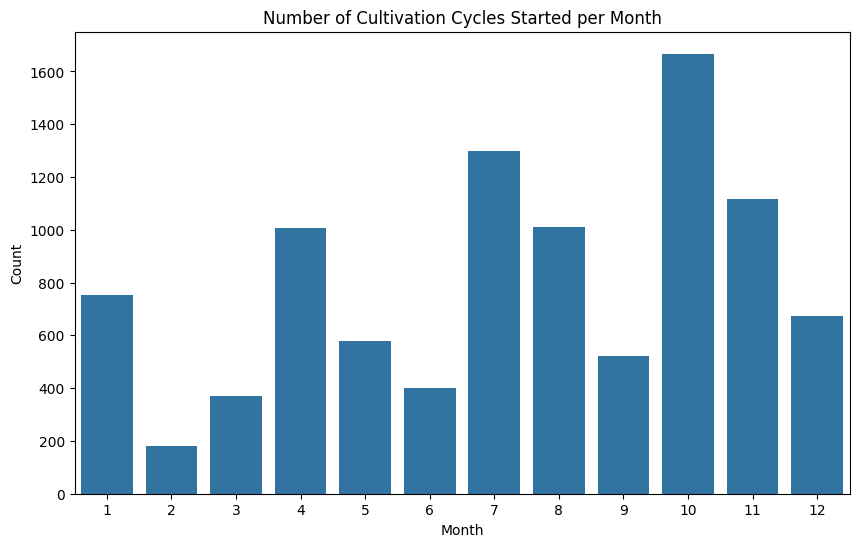

In [9]:
# Convert 'started_at' and 'finished_at' to datetime
df['started_at'] = pd.to_datetime(df['started_at'])
df['finished_at'] = pd.to_datetime(df['finished_at'])

# Extract month and year from 'started_at'
df['start_month'] = df['started_at'].dt.month
df['start_year'] = df['started_at'].dt.year

# Plot the number of cultivation cycles started per month
plt.figure(figsize=(10, 6))
sns.countplot(x='start_month', data=df)
plt.title('Number of Cultivation Cycles Started per Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

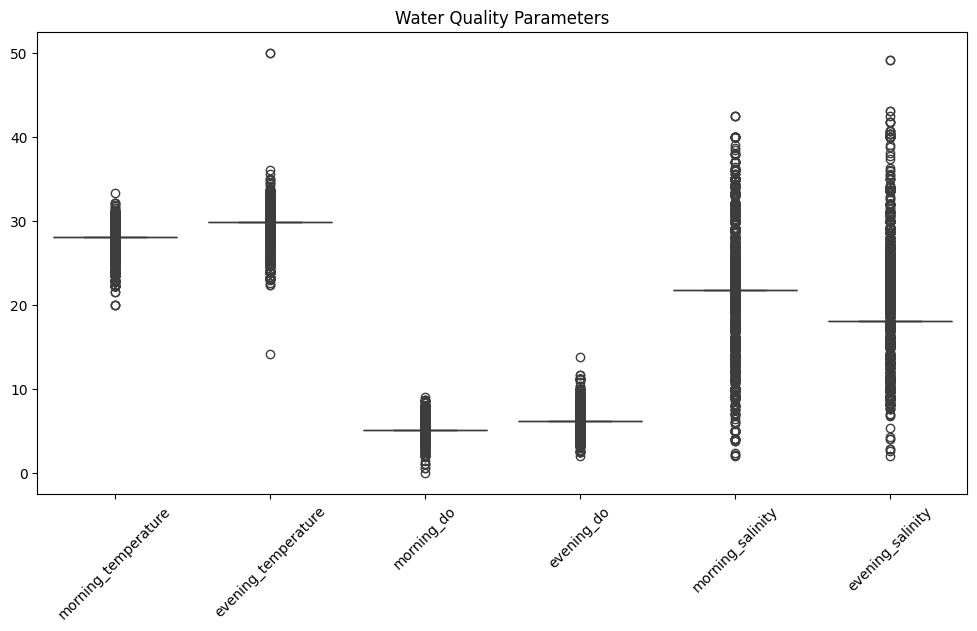

In [10]:
#Water Quality Analysis
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[["morning_temperature", "evening_temperature", "morning_do", "evening_do", "morning_salinity", "evening_salinity"]])
plt.xticks(rotation=45)
plt.title("Water Quality Parameters")
plt.show()

In [11]:
# Select only numeric columns for IQR calculation
numeric_data = df.select_dtypes(include=[np.number])

# Calculate IQR for numeric columns
Q1 = numeric_data.quantile(0.25)
Q3 = numeric_data.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = (numeric_data < (Q1 - 1.5 * IQR)) | ((numeric_data > (Q3 + 1.5 * IQR)))

# Print rows with outliers
display(df[outliers.any(axis=1)])

,id_farm,province,regency,timezone,id_pond,farm_id,length,width,deep,created_at_pond,...,updated_at_harvests,size,created_at_harvests,weight,id_harvests,harvested_at,status,selling_price,start_month,start_year
5,12537.0,SULAWESI BARAT,MAMUJU UTARA,+07:00,5.0,3.0,45.81,33.0,1.1,2018-03-07 19:05:09.000,...,2022-10-06 05:10:14,79.0,2020-07-02 06:40:12,199.7,2306.0,2020-07-02,Partial,12414950.0,4,2020
6,12537.0,SULAWESI BARAT,MAMUJU UTARA,+07:00,5.0,3.0,45.81,33.0,1.1,2018-03-07 19:05:09.000,...,2022-10-06 05:10:14,79.0,2020-07-02 06:40:12,199.7,2306.0,2020-07-02,Partial,12414950.0,4,2020
7,12537.0,SULAWESI BARAT,MAMUJU UTARA,+07:00,5.0,3.0,45.81,33.0,1.1,2018-03-07 19:05:09.000,...,2022-10-06 05:10:14,79.0,2020-07-02 06:40:12,199.7,2306.0,2020-07-02,Partial,12414950.0,4,2020
8,12537.0,SULAWESI BARAT,MAMUJU UTARA,+07:00,5.0,3.0,45.81,33.0,1.1,2018-03-07 19:05:09.000,...,2022-10-06 05:10:14,79.0,2020-07-02 06:40:12,199.7,2306.0,2020-07-02,Partial,12414950.0,4,2020
9,12537.0,SULAWESI BARAT,MAMUJU UTARA,+07:00,5.0,3.0,45.81,33.0,1.1,2018-03-07 19:05:09.000,...,2022-10-06 05:10:14,79.0,2020-07-02 06:40:12,199.7,2306.0,2020-07-02,Partial,12414950.0,4,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11129,12537.0,SULAWESI BARAT,MAMUJU UTARA,+07:00,5.0,3.0,45.81,33.0,1.1,2018-03-07 19:05:09.000,...,2022-10-06 05:25:50,72.0,2022-06-21 08:04:03,150.0,16458.0,2023-03-12,Partial,5064000.0,2,2024
11131,12537.0,SULAWESI BARAT,MAMUJU UTARA,+07:00,5.0,3.0,45.81,33.0,1.1,2018-03-07 19:05:09.000,...,2024-03-31 23:31:48,140.0,2024-03-31 23:31:48,330.0,28159.0,2024-03-30,Full,16500000.0,2,2024
11139,12537.0,SULAWESI BARAT,MAMUJU UTARA,+07:00,5.0,3.0,45.81,33.0,1.1,2018-03-07 19:05:09.000,...,2024-04-03 15:36:51,85.0,2024-04-03 05:20:38,1038.0,28263.0,2024-03-25,Full,57401400.0,1,2024
11140,12537.0,SULAWESI BARAT,MAMUJU UTARA,+07:00,5.0,3.0,45.81,33.0,1.1,2018-03-07 19:05:09.000,...,2024-04-03 15:36:51,85.0,2024-04-03 05:20:38,1038.0,28263.0,2024-03-25,Full,57401400.0,1,2024


/tmp/ipykernel_582303/3875056808.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=x["month_harvested_at"], y=x["selling_price"], ci=None)


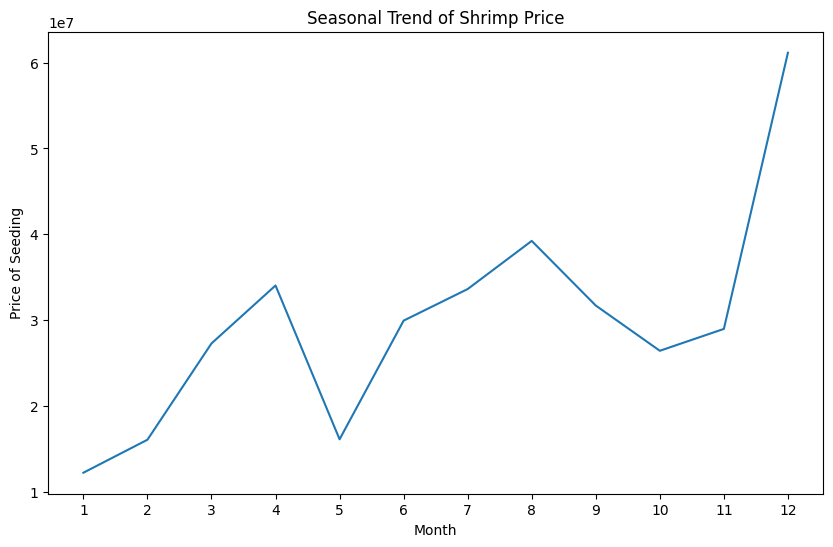

In [12]:
#Seasonal Trend Analysis
df["harvested_at"] = pd.to_datetime(df["harvested_at"], errors="coerce")
df["month_harvested_at"] = df["harvested_at"].dt.month
x = df[['month_harvested_at', 'selling_price']].drop_duplicates()

plt.figure(figsize=(10, 6))
sns.lineplot(x=x["month_harvested_at"], y=x["selling_price"], ci=None)
plt.xticks(range(1, 13))
plt.title("Seasonal Trend of Shrimp Price")
plt.xlabel("Month")
plt.ylabel("Price of Seeding")
plt.show()

/tmp/ipykernel_582303/1571984707.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=df["month"], y=df["total_seed"], ci=None)


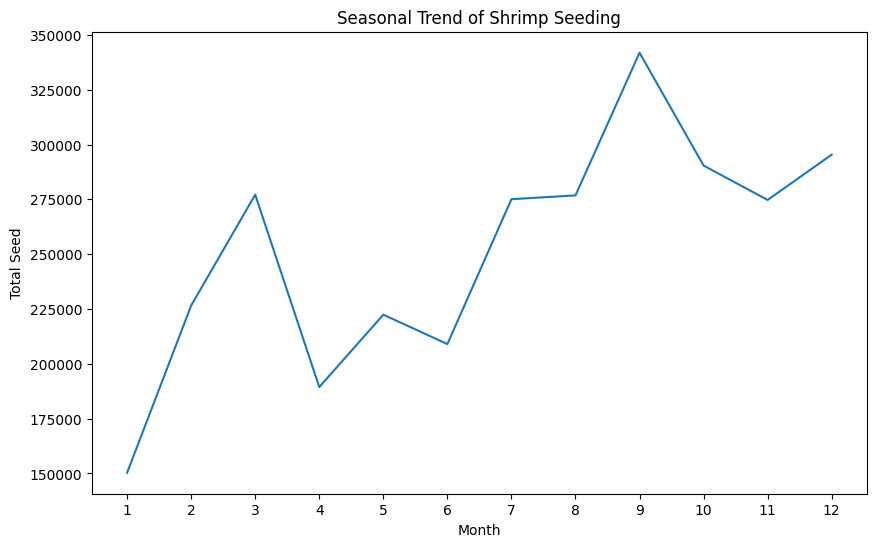

In [13]:
#Seasonal Trend Analysis
df["started_at"] = pd.to_datetime(df["started_at"], errors="coerce")
df["month"] = df["started_at"].dt.month
y = df[['month', 'total_seed']].drop_duplicates()

plt.figure(figsize=(10, 6))
sns.lineplot(x=df["month"], y=df["total_seed"], ci=None)
plt.xticks(range(1, 13))
plt.title("Seasonal Trend of Shrimp Seeding")
plt.xlabel("Month")
plt.ylabel("Total Seed")
plt.show()

In [14]:
# stocking density (shrimp/m2)
df["stocking_density"] = df["total_seed"] / df["area"]

# feed conversion ratio
df["fcr"] = df["quantity"] / df["average_weight"]

df[['stocking_density','fcr']]

,stocking_density,fcr
5,203.883495,0.622074
6,203.883495,0.643599
7,203.883495,1.576271
8,203.883495,0.784810
9,203.883495,0.861111
...,...,...
11129,394.736842,1.071429
11131,106.951872,1.071429
11139,138.888889,1.071429
11140,138.888889,1.071429


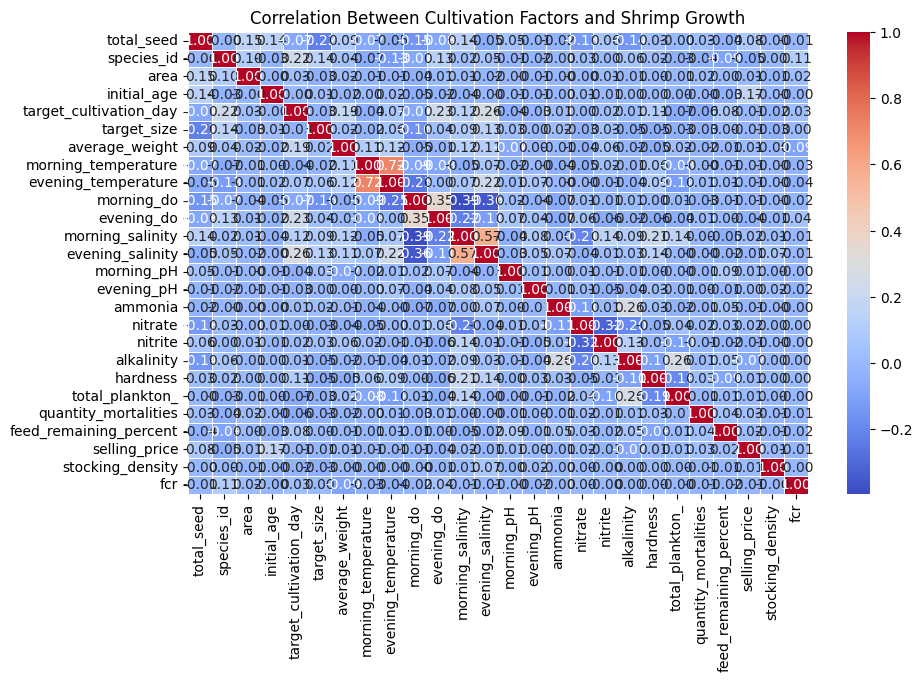

In [15]:
# Select relevant columns
columns_of_interest = [
    "total_seed", "species_id", "area", "initial_age", "target_cultivation_day", 
    "target_size", "average_weight", "morning_temperature", "evening_temperature", 
    "morning_do", "evening_do", "morning_salinity", "evening_salinity", 
    "morning_pH", "evening_pH", "ammonia", "nitrate", "nitrite", "alkalinity", 
    "hardness", "total_plankton_", "quantity_mortalities", "feed_remaining_percent", 
    "selling_price", "stocking_density", "fcr"
]

# Compute correlation
corr_matrix = df[columns_of_interest].corr()

# Heatmap for visualization
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Cultivation Factors and Shrimp Growth")
plt.show()

## Calculate Key Metrics

In [16]:
### -- Survival Rate
def calculate_survival_rate(df, initial_stocking_col, size_col, weight_col):
    df = df.copy()
    # Replace invalid values with NaN
    df.loc[df[initial_stocking_col] <= 0, initial_stocking_col] = float('nan')
    df.loc[df[size_col] <= 0, size_col] = float('nan')
    df.loc[df[weight_col] <= 0, weight_col] = float('nan')
    
    # Calculate harvest population and survival rate
    harvest_population = df[size_col] * df[weight_col]
    survival_rate = (harvest_population / df[initial_stocking_col]) * 100
    return survival_rate.round(2)


### -- Average Daily Gain (ADG)
def calculate_adg(df, cycle_id_col, sampled_at_col, weight_col):
    df = df.copy() 
    df[sampled_at_col] = pd.to_datetime(df[sampled_at_col], errors="coerce")
    df = df.dropna(subset=[sampled_at_col]) 
    df = df.sort_values([cycle_id_col, sampled_at_col]) 

    # Calculate ADG: weight difference / days difference
    df["adg"] = (
        df.groupby(cycle_id_col)[weight_col].diff() /
        df.groupby(cycle_id_col)[sampled_at_col].diff().dt.days
    )
    
    return df["adg"] 

In [17]:
df['survival_rate'] = calculate_survival_rate(df, initial_stocking_col="total_seed", size_col="size", weight_col="weight")

# Calculate ADG
df['adg'] = calculate_adg(df, cycle_id_col="cycle_id", sampled_at_col="sampled_at", weight_col="average_weight")

df.to_csv("clean_new.csv",index=False)